<a href="https://colab.research.google.com/github/NAVEED261/MY-AI-ASSISTANT/blob/main/Part_6_Customizing_State_%26_part_7_Time_Travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:

%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community


"Ab tak hum ne aik simple state ka sahara liya hai (yeh bas aik messages ki list hai!). Is simple state ke saath aap kaafi aagay ja sakte hain, lekin agar aap complex behavior define karna chahtay hain baghair message list par depend kiye, toh aap state mein additional fields add kar sakte hain. Iss section mein hum apne chat bot ko aik naye node ke saath expand karenge isko illustrate karne ke liye.

Pehle walay examples mein hum ne aik insaan ko deterministic tor par involve kiya: jab bhi tool invoke kiya gaya, graph hamisha interrupt ho jata tha. Tasavvur karein agar hum chahte hain ke hamara chat bot aik insaan par depend karne ka ikhtiyar rakhta ho.

Iska aik tareeqa yeh hai ke aik passthrough 'human' node create kiya jaye, jisse pehle graph hamisha ruk jaaye. Hum sirf yeh node tab execute karenge agar LLM 'human' tool ko invoke kare. Apni sahulat ke liye hum graph state mein aik 'ask_human' flag shamil karenge jo hum flip karenge agar LLM is tool ko bulaye.

Neeche, is naye graph ko define karen, aik updated State ke saath."

In [59]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('my_stenographer_key')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [60]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults # Import the necessary class
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("what is current weather in karachi")

[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'Karachi', 'region': 'Sindh', 'country': 'Pakistan', 'lat': 24.8667, 'lon': 67.05, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1731083585, 'localtime': '2024-11-08 21:33'}, 'current': {'last_updated_epoch': 1731083400, 'last_updated': '2024-11-08 21:30', 'temp_c': 26.1, 'temp_f': 79.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 8.5, 'wind_kph': 13.7, 'wind_degree': 254, 'wind_dir': 'WSW', 'pressure_mb': 1014.0, 'pressure_in': 29.94, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 79, 'cloud': 0, 'feelslike_c': 28.4, 'feelslike_f': 83.2, 'windchill_c': 27.4, 'windchill_f': 81.3, 'heatindex_c': 30.7, 'heatindex_f': 87.2, 'dewpoint_c': 23.0, 'dewpoint_f': 73.3, 'vis_km': 6.0, 'vis_miles': 3.0, 'uv': 0.0, 'gust_mph': 11.8, 'gust_kph': 19.0}}"},
 {'url': 'https://www.timeanddate.com/weather/pakistan/karachi/hourly',
  'content': 

In [61]:
from typing import Annotated


from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool
    # ask_human: bool ye ek flag ki trh kam krta ha jo human ko involve krna ha yes ya no ma


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str
# ek class bnai jo ya decide karagi k human ko invole krna ha ya ni


# "Ham LLM ko ek tool definition, Pydantic model, ya JSON schema ke saath bind kar sakte hain."
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])
# llm ko btarha ha k bind or requestassistance tool use krskta ho

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # llm ko call krrha ha k normal state pas krdo human ki need ni islya false kya
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}
# ager human ki need ho (["name"] == ReoquestAssistance.) to true krdo or query ko human k pas bhjdo

graph_builder = StateGraph(State)
# ub graph bnana start kya

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))
# jo b hum tool ki array ya list bnai ga wo tool node ma store ya convert hojaigi

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )
# this is helper function jo b human ka reply hoga wo toolmsg ma return hojai ya convert hoajaiga

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Amuman, user ne interrupt ke doran state ko update kiya hoga. Agar woh
        # update na karna chahein, toh hum ek placeholder ToolMessage include
        # karenge taake LLM continue kar sake
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
        # human ki is node ma ager human koi msg ni aya to new msg apend hojai ga
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }
# jo porana msg ki jga nes msg ma append hoga or human ko false krdaga k iski need ni ha

graph_builder.add_node("human", human_node)
# human ki node bnai gai ha

def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

#  ager state true ha to query human k pas bhjdo werna tool conditon p return krdo
# note : true or false hamasha llm decide krta ha q llm k bind.tool ha langraph
# k langraph ma work flow kya chlrha ha uska behalf p llm decide krta ha

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
# ya condition ha decide karagi k human k pas bhjna ha tool ya phr end krna ha

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human","chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
      #for persistance "" Persistence ka matlab hai data ya state ko mustaqil tor par save karna."
    interrupt_before=["human"],
)
#yha hmna human  interupt krna ha human ko.

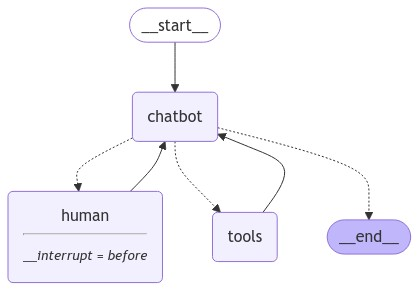

In [62]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

"Chatbot ya toh insani madad ka request kar sakta hai (chatbot->select->human), search engine tool ko invoke kar sakta hai (chatbot->select->action), ya seedha jawab de sakta hai (chatbot->select->end). Jab koi action ya request ki jati hai, graph wapas chatbot node par transition karega taake operations continue ho saken.

Aayein is graph ko action mein dekhte hain. Hum expert assistance ka request karenge taake apne

In [63]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "10"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (6e317345-70fb-4f0b-bc39-520a6071ddf7)
 Call ID: 6e317345-70fb-4f0b-bc39-520a6071ddf7
  Args:
    request: I need some expert guidance for building this AI agent.


In [64]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

Graph state waqai 'human' node se pehle interrupt hota hai. Iss scenario mein hum 'expert' ke tor par act kar sakte hain aur manually state ko update kar sakte hain by adding ek naya ToolMessage apne input ke sath.

Agla step ye hai ke chatbot ke request ka jawab dein by:

Apne response ke sath ek ToolMessage create karna jo chatbot ko wapas bhej diya jayega.
update_state ko call kar ke graph state ko manually update karna."

In [65]:
ai_message = snapshot.values["messages"][-1]

In [66]:

human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
# human na chatbot ko manulay response dya ha
tool_message = create_response(human_response, ai_message)
# human ka response or ai ki id bnarha hai jo tool msg ma store hojaiga.
graph.update_state(config, {"messages": [tool_message]})
# human ka response tool msg ma store hogya ha

{'configurable': {'thread_id': '10',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9def3-2174-6853-8002-b05c9a4dafb2'}}

In [67]:
tool_message

ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", id='ad22822b-eb6e-491e-a759-e8cb8671bcdb', tool_call_id='6e317345-70fb-4f0b-bc39-520a6071ddf7')

In [68]:
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()
# iska kaam hai chatbot ke state mein se messages retrieve karna.

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (6e317345-70fb-4f0b-bc39-520a6071ddf7)
 Call ID: 6e317345-70fb-4f0b-bc39-520a6071ddf7
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.


In [69]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend checking out LangGraph for building an AI agent. It's apparently more reliable and extensible than basic autonomous agents.


# ***Part 7: Time Travel¶***
Ek typical chatbot workflow mein, user ek ya us se zyada dafa bot ke saath interact karta hai taakay ek task ko poora kar sake. Pechlay sections mein, humne dekha ke kaise memory aur human-in-the-loop add ki ja sakti hai taakay apne graph state ko checkpoint kar sakein aur manually state ko override kar ke future responses ko control kar sakein.

Lekin agar aap chahte hain ke user kisi pehle wale response se shuru kare aur 'branch off' ho kar ek alag outcome explore kare? Ya agar aap users ko assistant ke kaam ko 'rewind' karne ka ikhtiyar dena chahte hain taakay wo kuch galtiyan theek kar saken ya ek mukhtalif strategy try kar saken (jo ke applications jaise autonomous software engineers mein aam hai)?

Aap in dono experiences aur is se bhi zyada kuch LangGraph ke built-in 'time travel' functionality ka istemal kar ke create kar sakte hain.

Is section mein, aap apne graph ko 'rewind' karenge by fetching ek checkpoint graph ke get_state_history method ka istemal kar ke. Phir aap execution ko iss pechlay waqt ke point par resume kar sakte hain.

Pehle, apne chatbot graph ko recall karen. Humein pehle se kisi bhi tareeke mein changes karne ki zaroorat nahi hai."








In [77]:
to_replay = None
for state in graph.get_state_history(config):

    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


"Note karen ke checkpoints har graph ke step ke liye save kiye jate hain. Yeh invocations ko span karte hain, is tarah aap poori thread ki history mein rewind kar sakte hain. Humne to_replay ko ek state ke tor par resume karne ke liye chuna hai. Yeh state upar wale second graph invocation mein chatbot node ke baad wali hai.

Is point se resume karne ka matlab hai ke agla action node call kiya jana chahiye."

In [80]:
snapshot = graph.get_state(config)

print(snapshot.next)
for m in graph.get_state(config).values["messages"]:
  m.pretty_print()

()
================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (6e317345-70fb-4f0b-bc39-520a6071ddf7)
 Call ID: 6e317345-70fb-4f0b-bc39-520a6071ddf7
  Args:
    request: I need some expert guidance for building this AI agent.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend checking out LangGraph for building an AI agent. It's apparently more reliable and extensible than basic autonomous agents.


In [73]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Okay, I've requested assistance from an expert. They recommend checking out LangGraph for building an AI agent. It's apparently more reliable and extensible than basic autonomous agents.


"Note karein ke graph ne execution ko action node se resume kiya. Aap ye isliye keh sakte hain kyun ke sab se pehla value jo print hui hai wo hamare search engine tool ka response hai.

Mubarak ho! Ab aapne LangGraph mein time-travel checkpoint traversal ka istemal kar liya hai. Rewind kar ke alternative paths ko explore karne ki ability se debugging, experimentation, aur interactive applications ke liye kai new possibilities khulti hain.

Conclusion: Mubarak ho! Aapne intro tutorial mukammal kar liya aur LangGraph mein ek aisa chatbot build kiya jo tool calling, persistent memory, human-in-the-loop interactivity, aur hatta ke time-travel ko support karta hai!

LangGraph documentation ek zabardast resource hai jo library ki capabilities mein aur gehraai se jane ke liye madadgar hai."